--------------------------
# Modèle CNN - polarité des labels
- Lucie MASSELIN
--------------------------

## 1. Chargement et échantillonnage

In [ ]:
import os

FILE_PATH = r'C:\Users\lucie\OneDrive\Documents\SEMESTRE_6\S6C01-test\data\yelp_academic_reviews4students.jsonl'

if os.path.exists(FILE_PATH):
    print(f"Fichier trouvé. Taille : {round(os.path.getsize(FILE_PATH)/1024/1024, 2)} Mo")
else:
    print("ERREUR : Le fichier n'existe pas au chemin indiqué.")
    
# Compter les lignes (1 ligne = 1 avis JSON)
with open(FILE_PATH, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f)

print("Nombre de lignes (avis) :", n_lines)


Fichier trouvé. Taille : 719.56 Mo
Nombre de lignes (avis) : 1000000


In [ ]:
import pandas as pd

# Charger tout le dataset JSONL 
df_review = pd.read_json(FILE_PATH, lines=True)
df_sample = df_review.sample(n = 20000, random_state = 42) # Tirer 10 000/ 50 000 lignes au hasard
print(f"Nombre de lignes dans df_sample : {len(df_sample)} avis")

Nombre de lignes dans df_sample : 20000 avis


## 2. Pré traitement

In [ ]:
df = df_sample[["review_id", "business_id", "stars", "text"]].copy()
df = df.dropna(subset=["text", "stars"]).reset_index(drop=True)

print("Shape:", df.shape)
df.head(10)

Shape: (20000, 4)


,review_id,business_id,stars,text
0,57Xa8920BrAjNOfqPgFt4Q,_C7QiQQc47AOEv4PE3Kong,1,I'm not quite sure what the hype is all about ...
1,Edkm3QufPBZTxtiWvTjcsQ,MxRZHZoDVVnN7EvMAHf1EA,5,Fleming's for a special occasion or just dinne...
2,HL6_YRk1ZKzfsF_2it7jFg,wu2nJ5lW0tCU3VYa80i8Uw,4,We found this location clean and well-kept. I ...
3,cYp4OouZBSsup6YE1CR73A,u-PhwpLtNmNIjOPo3jTjfw,5,My husband has been coming here for a few year...
4,WzgGRZVVI9HvR-2QCOTtHQ,yK8LWJ4VRTYEoGxVYzcjQg,1,Been here twice since they've opened. Was cert...
5,fyRZd1jVRkrsWs33llCONQ,MOowZBGbgn7FrTol3dvrlg,4,I was pleasantly surprised during our first vi...
6,UgzM4JQOiz-GfAwH3r6OdA,y930pQM0EUblQluRLkXLQg,5,We are very particular about our food . My hus...
7,NJKEs91GuNZVdz6TZTCQWg,IK4iU_hsbzLPbRhZRv1jrw,1,This is a halfway descent motel 6 but there's ...
8,3xU7xswtkPZzN3zSf5fKHg,34Eqv8jXgxg_EEwcsNgeeg,5,We tried looking for some brunch places that w...
9,prYct0PPAkOvUtl3ShDUWw,4r6N_Fhiwoqo_FqQ7Mm6mQ,5,Came back to Tucson to visit family and I'm go...


## 3. Visualisation pPolarité des labels

In [ ]:
import re
from langdetect import detect, LangDetectException

def label_polarity(score):
    if score > 3: return "positif"
    elif score < 3: return "négatif"
    else: return "neutre"

# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Application sur le dataframe
print("Détection de la langue en cours (ça peut prendre quelques secondes)...")
df['lang'] = df['text'].apply(detect_language)

# Filtrage : On ne garde que l'anglais ('en')
print(f"Avant filtrage : {len(df)} avis")
df = df[df['lang'] == 'en'].reset_index(drop=True)
print(f"Après filtrage (Anglais uniquement) : {len(df)} avis")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)       # enlever liens
    text = re.sub(r"[^a-z\s']", " ", text)     # garder lettres
    text = re.sub(r"\s+", " ", text).strip()   # espaces propres
    return text

print("Nettoyage des textes et création des labels...")
df["label"] = df["stars"].apply(label_polarity)
df["text_clean"] = df["text"].astype(str).apply(clean_text)

df[["stars", "label", "text_clean"]].head(10)

Détection de la langue en cours (ça peut prendre quelques secondes)...
Avant filtrage : 20000 avis
Après filtrage (Anglais uniquement) : 19981 avis
Nettoyage des textes et création des labels...


,stars,label,text_clean
0,1,négatif,i'm not quite sure what the hype is all about ...
1,5,positif,fleming's for a special occasion or just dinne...
2,4,positif,we found this location clean and well kept i o...
3,5,positif,my husband has been coming here for a few year...
4,1,négatif,been here twice since they've opened was certa...
5,4,positif,i was pleasantly surprised during our first vi...
6,5,positif,we are very particular about our food my husba...
7,1,négatif,this is a halfway descent motel but there's a ...
8,5,positif,we tried looking for some brunch places that w...
9,5,positif,came back to tucson to visit family and i'm go...


## 4. Attribution de la calsse pour l'encodage
Le MLP préfère des chiffres (0, 1, 2) plutôt que "négatif", "neutre"...

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# On récupère le nombre de classes (ici 3) pour la couche de sortie du réseau
NUM_CLASSES = len(le.classes_)
print("Classes :", dict(zip(le.classes_, le.transform(le.classes_))))

Classes : {'neutre': np.int64(0), 'négatif': np.int64(1), 'positif': np.int64(2)}


## 5. Séparation données Train/Test pour des labels

In [ ]:
from sklearn.model_selection import train_test_split

X = df['text_clean']
y = df['label_encoded']

# Découpage Entraînement / Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Répartition des notes (Rating) :")

rating_pct = df['label_encoded'].value_counts(normalize=True).sort_index()
print(rating_pct.map('{:.4f}'.format))

Répartition des notes (Rating) :
label_encoded
0    0.10
1    0.24
2    0.67
Name: proportion, dtype: object


--------

Les représentations de texte comme tf-idf , bm25 et sac de mots ne marchent pas avec une architecture CNN standard a la place j'utilise des tokenizer + embedding (transforme) pour :
- Le modèle ne sait pas lire des mots ("Food", "Bad"). Il ne comprend que des chiffres
- Le Tokenizer sert à construire un dictionnaire numéroté unique à ton dataset

------

EX: 
- Phrase : "The food was good"
- Sortie du Tokenizer : [1, 25, 12, 42]

------

### Tokenizer : Met les mots dans l'ordre et leur donne un numéro.

### Embedding : Donne du sens aux mots en les transformant en coordonnées mathématiques intelligentes.

------

- CNN : Il a besoin de lire la séquence pour appliquer ses filtres (ses "lunettes")
- BoW / BM25 / TF-IDF : Ce sont des méthodes "Bag of Words". Elles mélangent tous les mots dans un sac

## 6. Tokenizer (Dictionnaires numéroté unique)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight

MAX_WORDS = 20000
MAX_LEN = 100      # On coupe/complète les phrases à 100 mots

print("Tokenisation des textes pour le CNN")
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_raw) # On apprend le vocabulaire sur le train

# Transformation du texte en suites de chiffres
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Padding (Toutes les phrases doivent faire la même longueur)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"Dimension des données CNN : {X_train_pad.shape}")

# Calcul des poids
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

Tokenisation des textes pour le CNN...
Dimension des données CNN : (15984, 100)


## 7. Modèle CNN de l'apprentissage Deep Learning 

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

model_cnn = Sequential([
    # Couche 1 : Embedding (Transforme les chiffres en vecteurs de sens)
    Embedding(input_dim=MAX_WORDS, output_dim=50, input_length=MAX_LEN),
    
    # Couche 2 : Convolution 1D
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    
    # Couche 3 : Dense (Classification)
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(NUM_CLASSES, activation='softmax')
])

# Compilation
model_cnn.compile(
    loss='sparse_categorical_crossentropy', # 'sparse' car nos labels sont des entiers (0, 1, 2)
    optimizer='adam', 
    metrics=['accuracy']
    )

model_cnn.summary()

c:\Users\lucie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    restore_best_weights=True
)

print("\nDébut de l'entraînement du CNN")
history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test), # On valide sur le test pour voir la progression
    epochs=10, 
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict, # On injecte les poids calculés
    verbose=1
)


Début de l'entraînement du CNN...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6240 - loss: 0.9006 - val_accuracy: 0.6758 - val_loss: 0.7535
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7947 - loss: 0.5922 - val_accuracy: 0.7663 - val_loss: 0.5492
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8734 - loss: 0.3837 - val_accuracy: 0.8194 - val_loss: 0.4732
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9379 - loss: 0.2002 - val_accuracy: 0.8279 - val_loss: 0.5449
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9702 - loss: 0.0962 - val_accuracy: 0.8184 - val_loss: 0.6961
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9871 - loss: 0.0400 - val_accuracy: 0.8269 - val_loss: 0.7894


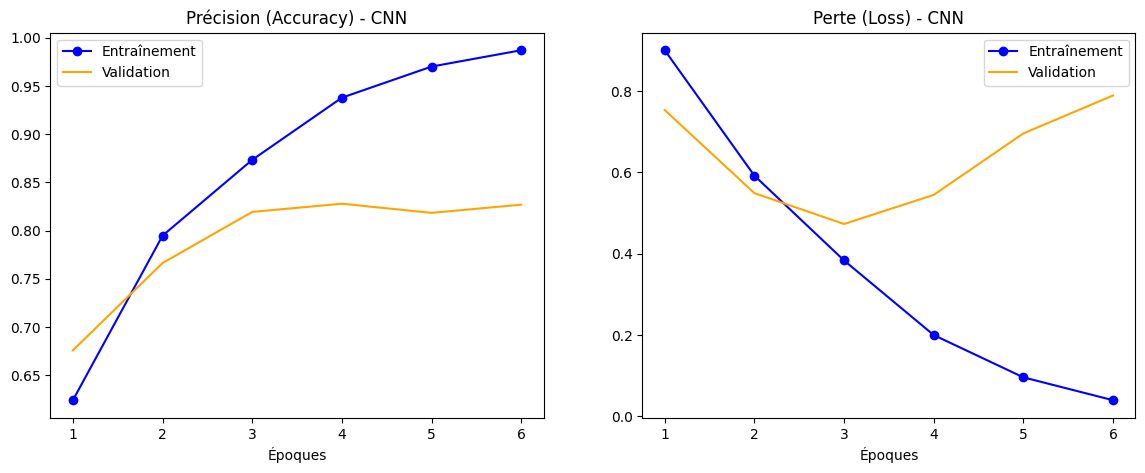

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


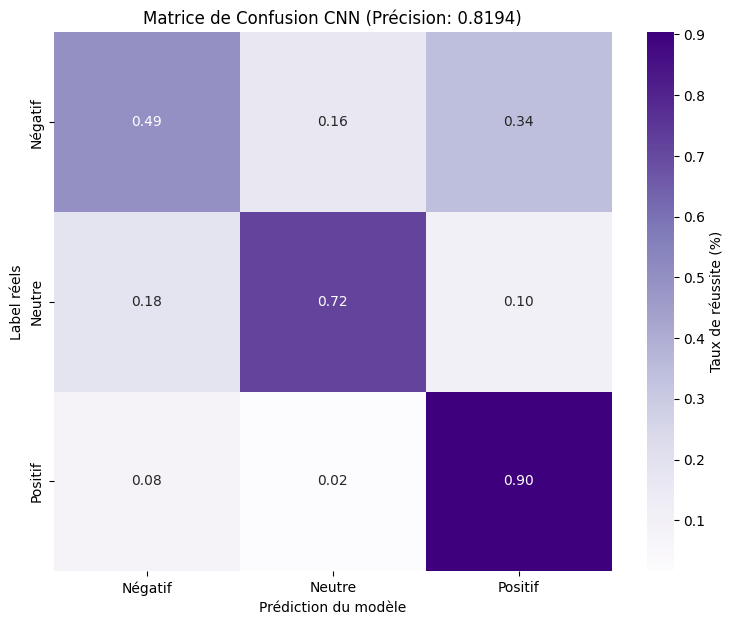

Précision (Accuracy) : 0.8194
F1-Score (ajusté selon la quantité d'avis par étoile)   : 0.8291
Perte (Log Loss)     : 0.4732

Rapport détaillé :
              precision    recall  f1-score   support

     Négatif       0.33      0.49      0.40       388
      Neutre       0.87      0.72      0.78       953
     Positif       0.91      0.90      0.91      2656

    accuracy                           0.82      3997
   macro avg       0.70      0.71      0.70      3997
weighted avg       0.85      0.82      0.83      3997



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Entraînement')
plt.plot(epochs_range, val_acc, 'orange', label='Validation')
plt.title('Précision (Accuracy) - CNN')
plt.xlabel('Époques')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Entraînement')
plt.plot(epochs_range, val_loss, 'orange', label='Validation')
plt.title('Perte (Loss) - CNN')
plt.xlabel('Époques')
plt.legend()
plt.show()

# Matrice de Confusion (Corrélation)
y_pred_probs = model_cnn.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_cnn = accuracy_score(y_test, y_pred)
f1_cnn = f1_score(y_test, y_pred, average='weighted')
loss_cnn = log_loss(y_test, y_pred_probs)

class_names = ['Négatif', 'Neutre', 'Positif']

plt.figure(figsize=(9, 7))
sns.heatmap(cm_norm, 
            annot=True, 
            fmt='.2f', 
            cmap='Purples',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Taux de réussite (%)'})

plt.xlabel('Prédiction du modèle')
plt.ylabel('Label réels')
plt.title(f'Matrice de Confusion CNN (Précision: {acc_cnn:.4f})')
plt.show()


print(f"Précision (Accuracy) : {acc_cnn:.4f}")
print(f"F1-Score (ajusté selon la quantité d'avis par étoile)   : {f1_cnn:.4f}")
print(f"Perte (Log Loss)     : {loss_cnn:.4f}")

print("\nRapport détaillé :")
print(classification_report(y_test, y_pred, target_names=class_names))

---------
## 8. Test phrase

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_custom_sentence_cnn(text, model, tokenizer, label_encoder, max_len=100):
    # Nettoyage
    text_clean = clean_text(text)

    # Transformation (Texte -> Séquence d'entiers)
    seq = tokenizer.texts_to_sequences([text_clean])

    # Padding (Ajout de zéros pour atteindre 100 mots)
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Prédiction
    prediction_probs = model.predict(padded, verbose=0)

    # Décodage
    predicted_index = np.argmax(prediction_probs)
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]
    
    print(f"Phrase : \"{text}\"")
    print(f"Sentiment prédit : {predicted_label.upper()}")
    print(f"Confiance : {prediction_probs[0][predicted_index]*100:.2f}%")
    print("-" * 30)

# --- ZONE DE TEST ---
phrases_a_tester = [
    "The food was amazing and the service was perfect!", 
    "It was terrible, I will never come back.", 
    "The food was okay but a bit expensive.", 
    "I don't know what to think about this place." 
]

print("--- TEST DU MODÈLE CNN ---\n")
for phrase in phrases_a_tester:
    predict_custom_sentence_cnn(phrase, model_cnn, tokenizer, le)

--- TEST DU MODÈLE CNN ---

Phrase : "The food was amazing and the service was perfect!"
Sentiment prédit : POSITIF
Confiance : 99.11%
------------------------------
Phrase : "It was terrible, I will never come back."
Sentiment prédit : NÉGATIF
Confiance : 99.66%
------------------------------
Phrase : "The food was okay but a bit expensive."
Sentiment prédit : NEUTRE
Confiance : 93.35%
------------------------------
Phrase : "I don't know what to think about this place."
Sentiment prédit : NÉGATIF
Confiance : 55.88%
------------------------------
